In [1]:
import numpy as np 
import pandas as pd

from glob import glob
from tqdm import tqdm

import keras
import keras.backend as K
import keras_cv


import librosa
import IPython.display as ipd
import librosa.display as lid

import matplotlib.pyplot as plt
import matplotlib as mpl
import os, gc
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import tensorflow as tf
import tensorflow_io as tfio

print('TensorFlow version =',tf.__version__)

# USE MULTIPLE GPUS
gpus = tf.config.list_physical_devices('GPU')
if len(gpus)<=1: 
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f'Using {len(gpus)} GPU')
else: 
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')

2024-06-10 08:31:29.597120: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 08:31:29.597260: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 08:31:29.761597: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version = 2.15.0
Using 0 GPU


In [2]:
cmap = mpl.cm.get_cmap('coolwarm')

/tmp/ipykernel_18/3764859085.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('coolwarm')


In [3]:
class CFG:
    seed = 42
    
    # Input image size and batch size
    img_size = [128, 384]
    batch_size = 64
    
    # Audio duration, sample rate, and length
    duration = 15 # second
    sample_rate = 32000
    audio_len = duration*sample_rate
    
    # STFT parameters
    nfft = 2028
    window = 2048
    hop_length = audio_len // (img_size[1] - 1)
    fmin = 20
    fmax = 16000
    
    # Number of epochs, model name
    epochs = 10
    preset = 'efficientnetv2_b2_imagenet'
    
    # Data augmentation parameters
    augment=True

    # Class Labels for BirdCLEF 24
    class_names = sorted(os.listdir('/kaggle/input/birdclef-2024/train_audio/'))
    num_classes = len(class_names)
    class_labels = list(range(num_classes))
    label2name = dict(zip(class_labels, class_names))
    name2label = {v:k for k,v in label2name.items()}

In [4]:
BASE_PATH = '/kaggle/input/birdclef-2024'


In [5]:
test_paths = glob(f'{BASE_PATH}/unlabeled_soundscapes/*ogg')
df = pd.DataFrame(test_paths, columns=['filepath'])

In [6]:
df.filepath[2891][50:-4]


'938167989'

In [7]:
# Decodes Audio
def build_decoder(with_labels=False, dim=CFG.audio_len):
    def get_audio(filepath):
        file_bytes = tf.io.read_file(filepath)
        audio = tfio.audio.decode_vorbis(file_bytes)  # decode .ogg file
        audio = tf.cast(audio, tf.float32)
        if tf.shape(audio)[1] > 1:  # stereo -> mono
            audio = audio[..., 0:1]
        audio = tf.squeeze(audio, axis=-1)
        return audio

    def crop_or_pad(audio, target_len, pad_mode="constant"):
        audio_len = tf.shape(audio)[0]
        diff_len = abs(
            target_len - audio_len
        )  # find difference between target and audio length
        if audio_len < target_len:  # do padding if audio length is shorter
            pad1 = tf.random.uniform([], maxval=diff_len, dtype=tf.int32)
            pad2 = diff_len - pad1
            audio = tf.pad(audio, paddings=[[pad1, pad2]], mode=pad_mode)
        elif audio_len > target_len:  # do cropping if audio length is larger
            idx = tf.random.uniform([], maxval=diff_len, dtype=tf.int32)
            audio = audio[idx : (idx + target_len)]
        return tf.reshape(audio, [target_len])

    def apply_preproc(spec):
        # Standardize
        mean = tf.math.reduce_mean(spec)
        std = tf.math.reduce_std(spec)
        spec = tf.where(tf.math.equal(std, 0), spec - mean, (spec - mean) / std)

        # Normalize using Min-Max
        min_val = tf.math.reduce_min(spec)
        max_val = tf.math.reduce_max(spec)
        spec = tf.where(
            tf.math.equal(max_val - min_val, 0),
            spec - min_val,
            (spec - min_val) / (max_val - min_val),
        )
        return spec


    def decode(path):
        # Load audio file
        audio = get_audio(path)
        # Crop or pad audio to keep a fixed length
#         audio = crop_or_pad(audio, dim)
        # Audio to Spectrogram
        spec = keras.layers.MelSpectrogram(
            num_mel_bins=CFG.img_size[0],
            fft_length=CFG.nfft,
            sequence_stride=CFG.hop_length,
            sampling_rate=CFG.sample_rate,
        )(audio)
        # Apply normalization and standardization
        spec = apply_preproc(spec)
        # Spectrogram to 3 channel image (for imagenet)
        spec = tf.tile(spec[..., None], [1, 1, 1])
#         spec = tf.reshape(spec, [128,-1, 1])
        return spec

    return decode

In [8]:
decoder=build_decoder()

In [9]:
row=df.iloc[1000]
a=row.filepath[50:-4]
b=np.array(decoder(row.filepath))[:,:,0]

In [10]:
b.shape

(128, 6130)

In [11]:
# display(ipd.Audio(librosa.load(row.filepath, sr=CFG.sample_rate)[0], rate=CFG.sample_rate))


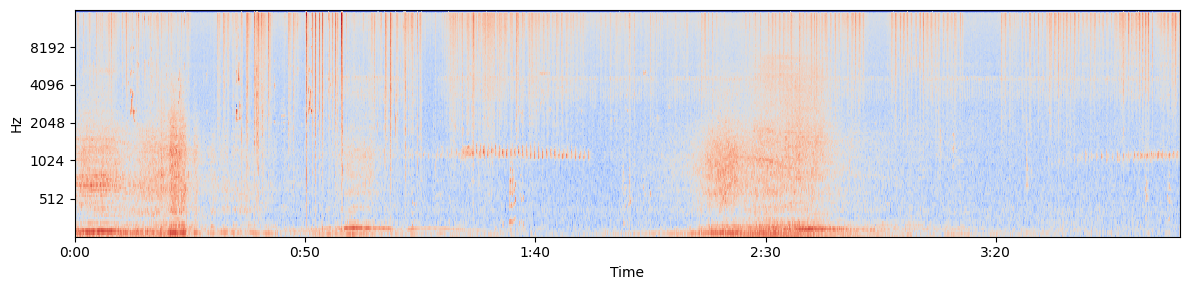

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12, 1*3), sharex=True, tight_layout=True)

lid.specshow(b, 
                 sr = CFG.sample_rate, 
                 hop_length=CFG.hop_length,
                 n_fft=CFG.nfft,
                 fmin=CFG.fmin,
                 fmax=CFG.fmax,
                 x_axis = 'time', 
                 y_axis = 'mel',
                 cmap = 'coolwarm',
                 ax=ax)
fig.show()

In [13]:
total_space=0

In [14]:
for i in tqdm(range(len(df))):
    if (i%100==0): print(i,', ',total_space,', ',end='')
    row=df.iloc[i]
    a=row.filepath[50:-4]
    b=np.array(decoder(row.filepath))[:,:,0]
    np.save(f"{a}.npy",b)
    total_space=total_space+b.nbytes/(1000*1000*1000);
    if(total_space>=19):
        print("break")
        print(i)
        print("left")
        print(len(df)-(i+1))
        break

  0%|          | 0/8444 [00:00<?, ?it/s]

0 ,  0 , 

  1%|          | 100/8444 [03:40<5:05:55,  2.20s/it]

100 ,  0.3118469120000007 , 

  2%|▏         | 200/8444 [07:16<5:01:04,  2.19s/it]

200 ,  0.6181934080000019 , 

  4%|▎         | 300/8444 [10:55<4:45:12,  2.10s/it]

300 ,  0.9293665280000031 , 

  5%|▍         | 400/8444 [14:35<4:57:08,  2.22s/it]

400 ,  1.2432225280000042 , 

  6%|▌         | 500/8444 [18:15<4:49:58,  2.19s/it]

500 ,  1.5570785280000055 , 

  7%|▋         | 600/8444 [21:52<4:47:11,  2.20s/it]

600 ,  1.8683586560000067 , 

  8%|▊         | 700/8444 [25:29<4:42:50,  2.19s/it]

700 ,  2.179451392000008 , 

  9%|▉         | 800/8444 [29:10<4:40:22,  2.20s/it]

800 ,  2.491222528000009 , 

 11%|█         | 900/8444 [32:51<4:36:16,  2.20s/it]

900 ,  2.8050785280000103 , 

 12%|█▏        | 1000/8444 [36:30<4:37:35,  2.24s/it]

1000 ,  3.1162603520000114 , 

 13%|█▎        | 1100/8444 [40:08<4:02:34,  1.98s/it]

1100 ,  3.4257408000000127 , 

 14%|█▍        | 1200/8444 [43:50<4:26:09,  2.20s/it]

1200 ,  3.7370880000000137 , 

 15%|█▌        | 1300/8444 [47:24<4:25:09,  2.23s/it]

1300 ,  4.041782784000015 , 

 17%|█▋        | 1400/8444 [51:02<4:16:41,  2.19s/it]

1400 ,  4.352924672000016 , 

 18%|█▊        | 1500/8444 [54:40<4:15:15,  2.21s/it]

1500 ,  4.659070464000018 , 

 19%|█▉        | 1600/8444 [58:19<4:09:37,  2.19s/it]

1600 ,  4.967564800000019 , 

 20%|██        | 1700/8444 [1:01:58<4:06:15,  2.19s/it]

1700 ,  5.27867955200002 , 

 21%|██▏       | 1800/8444 [1:05:45<4:06:11,  2.22s/it]

1800 ,  5.5925355520000215 , 

 23%|██▎       | 1900/8444 [1:09:24<3:48:24,  2.09s/it]

1900 ,  5.903806464000023 , 

 24%|██▎       | 2000/8444 [1:13:02<4:00:01,  2.23s/it]

2000 ,  6.212184576000023 , 

 25%|██▍       | 2100/8444 [1:16:42<3:54:47,  2.22s/it]

2100 ,  6.523388928000025 , 

 26%|██▌       | 2200/8444 [1:20:22<3:50:11,  2.21s/it]

2200 ,  6.837244928000026 , 

 27%|██▋       | 2300/8444 [1:24:06<3:47:39,  2.22s/it]

2300 ,  7.1488061440000275 , 

 28%|██▊       | 2400/8444 [1:27:46<3:41:30,  2.20s/it]

2400 ,  7.4584120320000284 , 

 30%|██▉       | 2500/8444 [1:31:24<3:39:47,  2.22s/it]

2500 ,  7.77029017600003 , 

 31%|███       | 2600/8444 [1:35:02<3:33:33,  2.19s/it]

2600 ,  8.08160614400003 , 

 32%|███▏      | 2700/8444 [1:38:46<3:30:41,  2.20s/it]

2700 ,  8.391729664000032 , 

 33%|███▎      | 2800/8444 [1:42:22<3:23:52,  2.17s/it]

2800 ,  8.700509696000033 , 

 34%|███▍      | 2900/8444 [1:46:03<3:25:30,  2.22s/it]

2900 ,  9.013700096000035 , 

 36%|███▌      | 3000/8444 [1:49:47<3:57:03,  2.61s/it]

3000 ,  9.324913152000036 , 

 37%|███▋      | 3100/8444 [1:53:36<3:21:56,  2.27s/it]

3100 ,  9.633532416000037 , 

 38%|███▊      | 3200/8444 [1:57:22<3:15:44,  2.24s/it]

3200 ,  9.947388416000038 , 

 39%|███▉      | 3300/8444 [2:01:12<3:13:41,  2.26s/it]

3300 ,  10.258481152000039 , 

 40%|████      | 3400/8444 [2:04:54<3:02:48,  2.17s/it]

3400 ,  10.56960512000004 , 

 41%|████▏     | 3500/8444 [2:08:36<3:04:58,  2.24s/it]

3500 ,  10.88065280000004 , 

 43%|████▎     | 3600/8444 [2:12:19<3:01:48,  2.25s/it]

3600 ,  11.191892480000043 , 

 44%|████▍     | 3700/8444 [2:16:10<2:58:39,  2.26s/it]

3700 ,  11.500765696000045 , 

 45%|████▌     | 3800/8444 [2:19:52<2:52:48,  2.23s/it]

3800 ,  11.809228288000044 , 

 46%|████▌     | 3900/8444 [2:23:38<2:50:59,  2.26s/it]

3900 ,  12.123084288000046 , 

 47%|████▋     | 4000/8444 [2:27:27<2:46:11,  2.24s/it]

4000 ,  12.431823872000047 , 

 49%|████▊     | 4100/8444 [2:31:13<2:43:45,  2.26s/it]

4100 ,  12.745679872000048 , 

 50%|████▉     | 4200/8444 [2:35:02<2:41:12,  2.28s/it]

4200 ,  13.054379520000051 , 

 51%|█████     | 4300/8444 [2:38:48<2:36:07,  2.26s/it]

4300 ,  13.368235520000052 , 

 52%|█████▏    | 4400/8444 [2:42:29<2:31:57,  2.25s/it]

4400 ,  13.677117952000053 , 

 53%|█████▎    | 4500/8444 [2:46:18<2:28:39,  2.26s/it]

4500 ,  13.988268544000054 , 

 54%|█████▍    | 4600/8444 [2:50:02<2:22:19,  2.22s/it]

4600 ,  14.300958720000056 , 

 56%|█████▌    | 4700/8444 [2:53:46<2:20:07,  2.25s/it]

4700 ,  14.612528640000058 , 

 57%|█████▋    | 4800/8444 [2:57:30<2:16:11,  2.24s/it]

4800 ,  14.926384640000059 , 

 58%|█████▊    | 4900/8444 [3:01:14<2:12:54,  2.25s/it]

4900 ,  15.24024064000006 , 

 59%|█████▉    | 5000/8444 [3:05:07<2:08:54,  2.25s/it]

5000 ,  15.554096640000061 , 

 60%|██████    | 5100/8444 [3:08:51<2:04:50,  2.24s/it]

5100 ,  15.867952640000063 , 

 62%|██████▏   | 5200/8444 [3:12:43<2:03:39,  2.29s/it]

5200 ,  16.181808640000064 , 

 63%|██████▎   | 5300/8444 [3:16:28<2:00:13,  2.29s/it]

5300 ,  16.493035008000064 , 

 64%|██████▍   | 5400/8444 [3:20:09<1:55:47,  2.28s/it]

5400 ,  16.800792064000063 , 

 65%|██████▌   | 5500/8444 [3:24:03<1:51:45,  2.28s/it]

5500 ,  17.114648064000065 , 

 66%|██████▋   | 5600/8444 [3:27:45<1:28:01,  1.86s/it]

5600 ,  17.425968128000065 , 

 68%|██████▊   | 5700/8444 [3:31:29<1:46:49,  2.34s/it]

5700 ,  17.737440256000067 , 

 69%|██████▊   | 5800/8444 [3:35:15<1:39:20,  2.25s/it]

5800 ,  18.051296256000068 , 

 70%|██████▉   | 5900/8444 [3:38:59<1:35:35,  2.25s/it]

5900 ,  18.362603008000068 , 

 71%|███████   | 6000/8444 [3:42:54<1:32:38,  2.27s/it]

6000 ,  18.673842688000068 , 

 72%|███████▏  | 6100/8444 [3:46:36<1:28:26,  2.26s/it]

6100 ,  18.98253312000007 , 

 72%|███████▏  | 6105/8444 [3:46:50<1:26:54,  2.23s/it]

break
6105
left
2338
